In [1]:
import ast
import pickle

import matplotlib.pyplot as plt
from matplotlib.colors import TABLEAU_COLORS

import numpy as np
import pandas as pd

from utils import plot_utils

In [ ]:
BASE_PATH = "../.."

GERDRACOR_DATA_PATH = f"{BASE_PATH}/data/gerdracor_names/gerdracor_names.tsv"
DFD_MOTIVE_DATA_PATH = f"{BASE_PATH}/data/dfd_aggregated/dfd-motives.tsv"

SVM_PATH = f"{BASE_PATH}/models/dfd-motives_svc.pkl"
VECTORIZER_PATH = f"{BASE_PATH}/models/dfd-motives_vectorizer.pkl"


# Load Data

In [3]:
df = pd.read_csv(GERDRACOR_DATA_PATH, sep="\t", index_col=0)
df

,date,name
text,,
ger000559,1902,Klemens
ger000559,1902,Margarete
ger000559,1902,Gilbert
ger000157,1774,Clavigo
ger000157,1774,Carlos
...,...,...
ger000537,1905,Jochanaan
ger000537,1905,Salome
ger000537,1905,Sklave


# Add Columns

In [4]:
df["surname"] = df["name"].str.split(" ").str[-1]
df["decade"] = df["date"].apply(lambda x: int(str(int(x))[:3] + "0"))
df

,date,name,surname,decade
text,,,,
ger000559,1902,Klemens,Klemens,1900
ger000559,1902,Margarete,Margarete,1900
ger000559,1902,Gilbert,Gilbert,1900
ger000157,1774,Clavigo,Clavigo,1770
ger000157,1774,Carlos,Carlos,1770
...,...,...,...,...
ger000537,1905,Jochanaan,Jochanaan,1900
ger000537,1905,Salome,Salome,1900
ger000537,1905,Sklave,Sklave,1900


# Load Classifier

In [5]:
with open(SVM_PATH, "rb") as f:
    svm = pickle.load(f)

with open(VECTORIZER_PATH, "rb") as f:
    vectorizer = pickle.load(f)

# Apply to Data

In [6]:
# took 9.2s
df["surname_motive"] = svm.predict(vectorizer.transform(df["surname"]))
df

,date,name,surname,decade,surname_motive
text,,,,,
ger000559,1902,Klemens,Klemens,1900,Rufname
ger000559,1902,Margarete,Margarete,1900,Rufname
ger000559,1902,Gilbert,Gilbert,1900,Rufname
ger000157,1774,Clavigo,Clavigo,1770,Rufname
ger000157,1774,Carlos,Carlos,1770,Rufname
...,...,...,...,...,...
ger000537,1905,Jochanaan,Jochanaan,1900,Rufname
ger000537,1905,Salome,Salome,1900,Rufname
ger000537,1905,Sklave,Sklave,1900,Rufname


# Look at Overall Distributions

In [7]:
gerdracor_motive_distribution_df = df["surname_motive"].value_counts().to_frame()
gerdracor_motive_distribution_df["relative"] = gerdracor_motive_distribution_df.div(gerdracor_motive_distribution_df.sum())
gerdracor_motive_distribution_df

,count,relative
surname_motive,,
Rufname,6237,0.661961
Beruf,1738,0.184462
Übername,653,0.069306
Herkunft,537,0.056994
Wohnstätte,257,0.027277


## ... in DFD Data

In [8]:
# Get raw labeled data
dfd_motive_df = pd.read_csv(DFD_MOTIVE_DATA_PATH, sep="\t", converters={2: ast.literal_eval})

# remove multilabeled names
dfd_motive_df = pd.DataFrame(dfd_motive_df.loc[dfd_motive_df["labels"].str.len() == 1].explode("labels"))
dfd_motive_df.rename(columns={"labels": "label"}, inplace=True)

# calc distributions
dfd_motive_distribution_df = dfd_motive_df["label"].value_counts().to_frame()
dfd_motive_distribution_df["relative"] = dfd_motive_distribution_df.div(dfd_motive_distribution_df.sum())
dfd_motive_distribution_df

,count,relative
label,,
Rufname,22675,0.416139
Beruf,13168,0.241663
Übername,6504,0.119364
Herkunft,6129,0.112481
Wohnstätte,5200,0.095432
kompositionelles Motiv,435,0.007983
Rufnamenmuster,307,0.005634
dynastisches Motiv,34,0.000624
patriotisches Motiv,28,0.000514


In [9]:
dfd_motive_dict = dfd_motive_df.set_index("text")["label"].to_dict()

# Check Coverage

In [10]:
gerdracor_surnames = set(df["surname"])
dfd_surnames = set(dfd_motive_df["text"])
found_names = list(set(gerdracor_surnames) & set(dfd_surnames))
print({
    "gerdracor": len(gerdracor_surnames),
    "DFD": len(dfd_surnames),
    "found": len(found_names),
    "missing": len(gerdracor_surnames) - len(found_names)
})

{'gerdracor': 5732, 'DFD': 54489, 'found': 638, 'missing': 5094}


# Investigate Decades (diachronically)

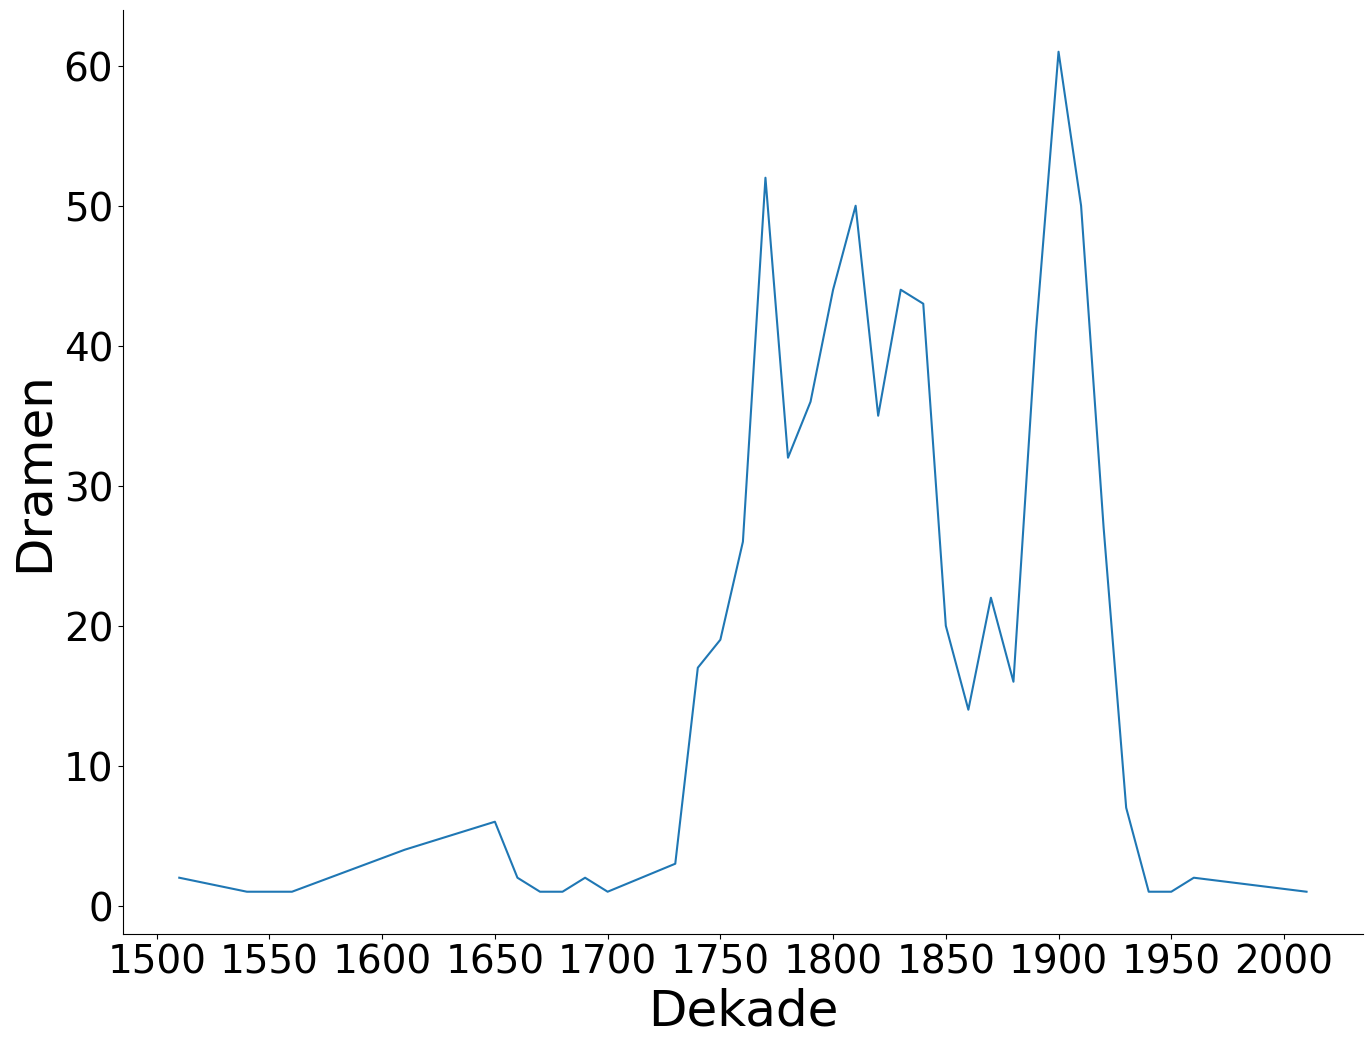

In [12]:
ax = df.reset_index().groupby("decade").agg({"text": "nunique"}).plot(figsize=plot_utils.FIGSIZE)
plot_utils.prepare_plot(ax, xlabel="Dekade", ylabel="Dramen")

ax.xaxis.set_ticks(np.arange(1500, 2010, 50))
ax.get_legend().remove();

In [13]:
motive_per_decade_df = df.reset_index().groupby(["decade", "surname_motive"]).agg({"text": "count"}).unstack("surname_motive").fillna(0).astype(int)
motive_per_decade_df = motive_per_decade_df.xs("text", axis=1, drop_level=True)
motive_per_decade_df["sum"] = motive_per_decade_df.sum(axis=1)
motive_per_decade_df

surname_motive,Beruf,Herkunft,Rufname,Wohnstätte,Übername,sum
decade,,,,,,
1510,2,0,4,0,0,6
1540,2,1,10,1,0,14
1560,4,0,6,0,4,14
1610,6,1,63,0,4,74
1650,12,3,71,3,5,94
1660,3,2,31,1,2,39
1670,2,1,26,0,6,35
1680,5,3,58,0,3,69
1690,8,0,16,2,6,32


In [14]:
relative_motive_per_decade_df = motive_per_decade_df.copy()
for column in relative_motive_per_decade_df.columns:
    relative_motive_per_decade_df[column] /= relative_motive_per_decade_df["sum"]
del relative_motive_per_decade_df["sum"]
relative_motive_per_decade_df = relative_motive_per_decade_df[["Beruf", "Herkunft", "Rufname", "Übername", "Wohnstätte"]]
relative_motive_per_decade_df

surname_motive,Beruf,Herkunft,Rufname,Übername,Wohnstätte
decade,,,,,
1510,0.333333,0.000000,0.666667,0.000000,0.000000
1540,0.142857,0.071429,0.714286,0.000000,0.071429
1560,0.285714,0.000000,0.428571,0.285714,0.000000
1610,0.081081,0.013514,0.851351,0.054054,0.000000
1650,0.127660,0.031915,0.755319,0.053191,0.031915
1660,0.076923,0.051282,0.794872,0.051282,0.025641
1670,0.057143,0.028571,0.742857,0.171429,0.000000
1680,0.072464,0.043478,0.840580,0.043478,0.000000
1690,0.250000,0.000000,0.500000,0.187500,0.062500


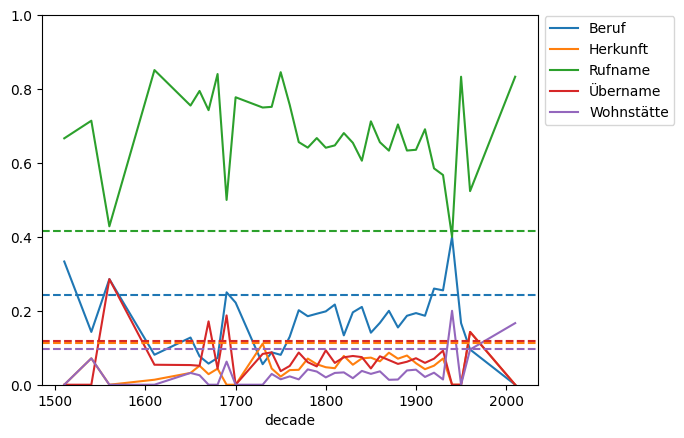

In [15]:
ax = relative_motive_per_decade_df.plot(ylim=(0,1))

colors = list(TABLEAU_COLORS.values())
dfd_distributions = dfd_motive_distribution_df["relative"].T.to_dict()
for i, motive in enumerate(relative_motive_per_decade_df.columns):
    plt.axhline(y=dfd_distributions[motive], color=colors[i], linestyle="--")
ax.legend(loc="center left", bbox_to_anchor=(1, .85))
plt.show()


## Ignore Decades with Small Amounts of Data

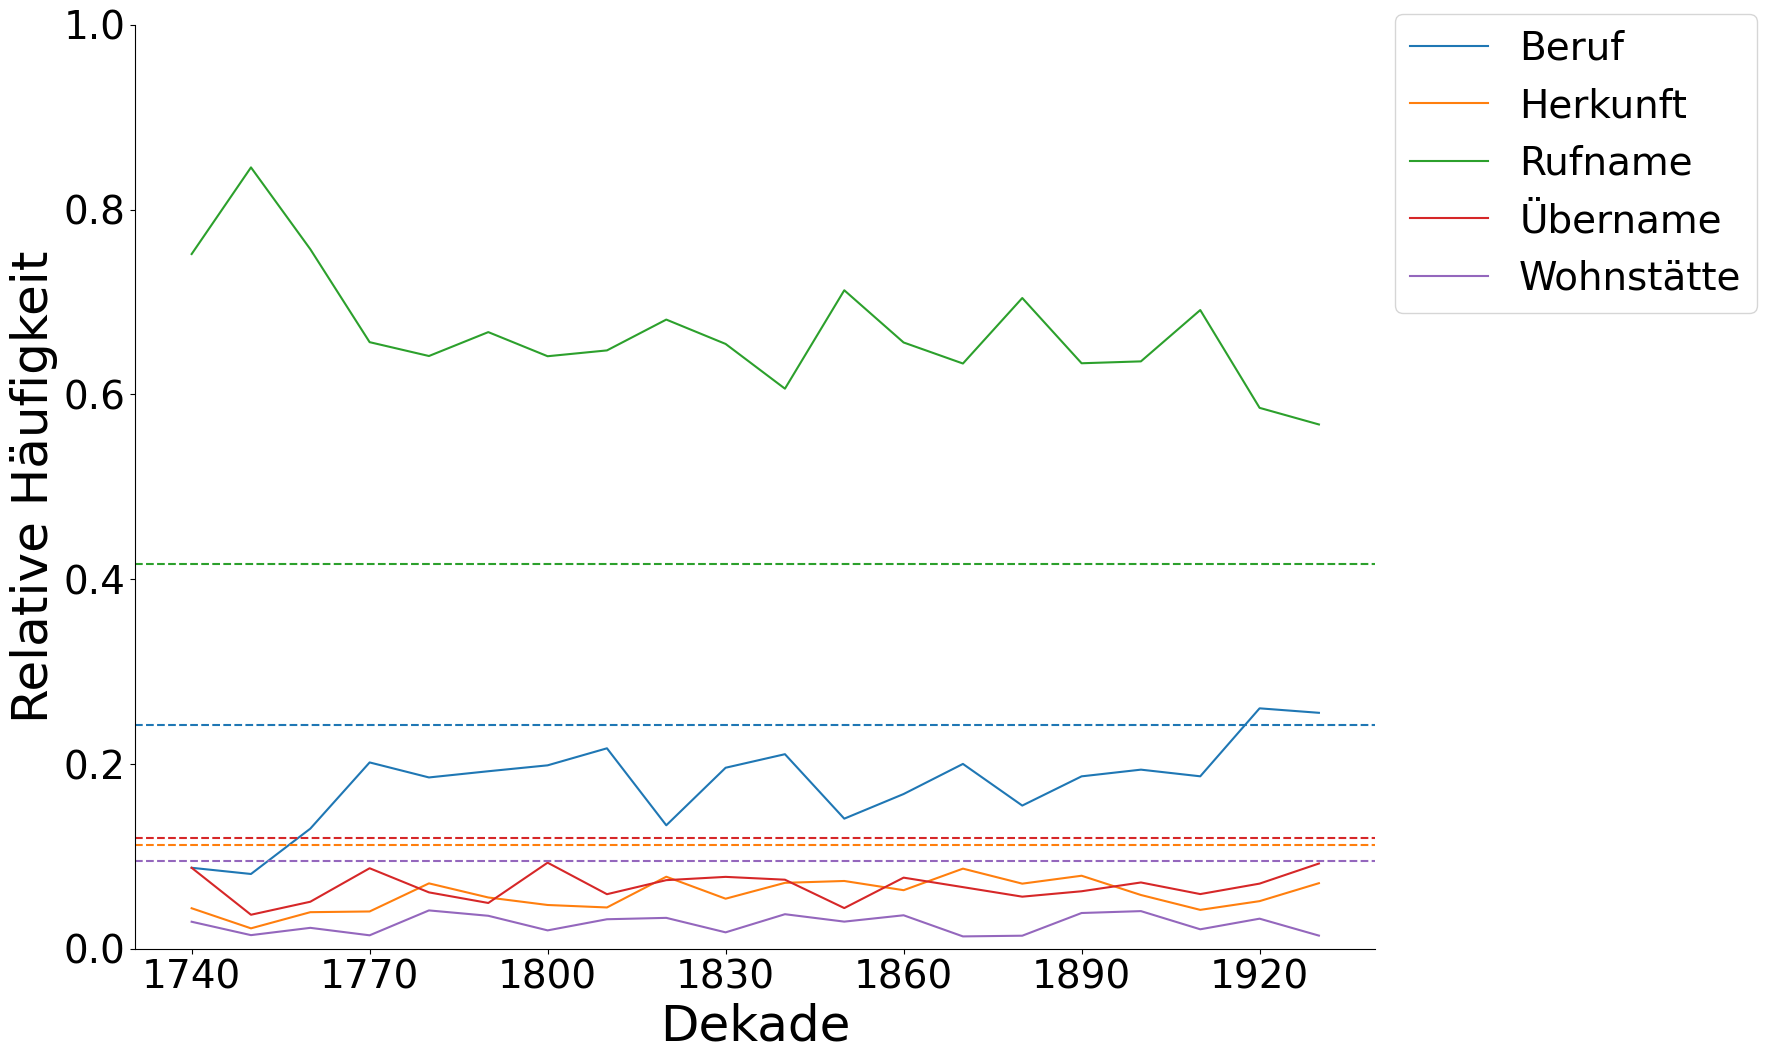

In [16]:
ax = relative_motive_per_decade_df.loc[motive_per_decade_df["sum"] > 100].plot(ylim=(0,1), figsize=plot_utils.FIGSIZE)

colors = list(TABLEAU_COLORS.values())
dfd_distributions = dfd_motive_distribution_df["relative"].T.to_dict()
for i, motive in enumerate(relative_motive_per_decade_df.columns):
    plt.axhline(y=dfd_distributions[motive], color=colors[i], linestyle="--")
ax.legend(loc="center left", bbox_to_anchor=(1, .85), prop={'size': plot_utils.TICK_SIZE})

start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(1740, 1950, 30))
plot_utils.prepare_plot(ax, xlabel="Dekade", ylabel="Relative Häufigkeit")

plt.show()